# Data Science - Capstone Project

### 1) Introduction/Business Problem

### 2) Data




### importing the libraries:

In [254]:
import numpy as np # library to handle data in a vectorized manner
from bs4 import BeautifulSoup

# use module dotenv to manage API keys and secrets
import os
%load_ext dotenv
%dotenv

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)

import json # library to handle JSON files
import re # library for regular expressions

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.geocoders import ArcGIS # convert an address into latitude and longitude values


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Libraries imported.


### Data gathering

Data sources:
- http://insideairbnb.com/get-the-data.html - data sourced from publicly available information from the Airbnb site.

Insideairbnb 


defining helper functions for downloading data with BeautifulSoup

In [255]:
data_folder = "./data/airbnb"

def download_airbnb_data(city):
    url_airbnb = "http://insideairbnb.com/get-the-data.html"
    search = city.lower()
    print(search)
    website_url = requests.get(url_airbnb).text
    soup = BeautifulSoup(website_url,'html.parser')
    table = soup.find('table',{'class':search})
    city_folder = f"{data_folder}/airbnb_{search}"
    if (table):
        print(search + " found. Looking for files ...")
        try:
            os.mkdir(city_folder)
        except FileExistsError:
            print('Directory already exists, not created.')
    trs = table.find_all('tr', class_=lambda x: x != 'archived')
    for tr in trs:
        a = tr.find_all('a')
        for link in a:
            #print(link['href'])
            #print(re.search('csv$',link['href']))
            if (re.search('[(csv)|(geojson)]$',link['href'])):
                print("downloading: " + link['href'])
                r = requests.get(link['href'])
                #print(r)
                #print(link.text)
                with open(city_folder +'/' + (link.text).strip(), 'wb') as f:
                    f.write(r.content)

def download_airbnb_data_list(cities):
    for city in cities:
        download_airbnb_data(city)
    print("download done")

In [256]:
cities = ['vienna']
download_airbnb_data_list(cities)

vienna


KeyboardInterrupt: 

In [252]:
def get_city_listings(city):
    city = city.lower()
    print(city)
    try:
        df = pd.read_csv(f"{data_folder}/airbnb_{city}/listings.csv")
        df['city'] = city
        
       # print(mean_size)
                #print(df)
    except FileNotFoundError:
        print("files not yet downloaded.")
        return None
    return df

def get_nbh_from_listings(df_listings):
    #print(df_listings)
    df_nbh=df_listings.groupby(['neighbourhood']).agg({'longitude':'mean', 'latitude':'mean'}).reset_index() 
    
    #get count listings per neighbourhood
    df_nbh_groups = df_listings.groupby(['neighbourhood']).id.size().reset_index().rename(columns={'id':'cnt_p_nbh'})[['neighbourhood','cnt_p_nbh']]
    [mean_cnt, std_cnt] = df_nbh_groups.cnt_p_nbh.agg(['median','std'])
    df_nbh_groups['cnt_norm'] = (df_nbh_groups['cnt_p_nbh'] - mean_cnt) / std_cnt
    
    # get distribution of room types per neighbourhood:
    df_rt_nbh = pd.concat([df_listings['neighbourhood'], pd.get_dummies(df_listings.room_type)], axis=1).groupby('neighbourhood').mean()
   # df_nbh_room_type = pd.get_dummiees(df_listings.groupby('neighbourhood').mean()
    #df_nbh = df_nbh.join(df_listings.groupby(['neighbourhood']).price.agg([lambda x: (x.mean() - df_listings.price.mean())/df_listings.price.std()]), on='neighbourhood')
    df_nbh = df_nbh.join(df_listings.groupby(['neighbourhood']).agg({'price':lambda x: (x.mean() - df_listings.price.mean())/df_listings.price.std()}), on='neighbourhood')
    df_nbh.rename(columns={'<lambda_0>':'price'})
    df_nbh['city']=df_listings['city'].head(1).values[0]
    
    # merge with data frame room types
    df_nbh = df_nbh.merge(df_rt_nbh, left_on='neighbourhood', right_index=True)
    df_nbh = df_nbh.merge(df_nbh_groups, left_on='neighbourhood', right_on='neighbourhood')
    
    #merge with dataframe count listings:
    
    
    #df_nbh['cnt_listings']=df_nbh.groupby('neighbourhood').psize()
    df_nbh['geojson'] = get_nbh_geojson(df_listings['city'].head(1).values[0])
    return df_nbh
def get_nbh_geojson(city):
    city = city.lower() 
    path = f"{data_folder}/airbnb_{city}/neighbourhoods.geojson"
    if (os.path.exists(path)):
        return path
    else:
        return "NA"

def get_city_dfs(cities):
    list_cities=[]
    for city in cities:
        city = city.lower()
        df_city = get_city_listings(city)
        df_nbh = get_nbh_from_listings(df_city)
        list_cities.append(df_nbh)
    return pd.concat(list_cities)
   

In [234]:
cities = [
    'vancouver'
]
df = get_city_dfs(cities).reset_index(drop=True)
df

vancouver


,neighbourhood,longitude,latitude,price,city,...,Private room,Shared room,cnt_p_nbh,cnt_norm,geojson
0,Arbutus Ridge,-123.164141,49.249279,0.022838,vancouver,...,0.434343,0.000000,99,-0.321183,./data/airbnb/airbnb_vancouver/neighbourhoods....
1,Downtown,-123.119366,49.278921,0.182609,vancouver,...,0.123223,0.002708,1477,4.387227,./data/airbnb/airbnb_vancouver/neighbourhoods....
2,Downtown Eastside,-123.099741,49.280940,0.068606,vancouver,...,0.136905,0.005952,336,0.488609,./data/airbnb/airbnb_vancouver/neighbourhoods....
3,Dunbar Southlands,-123.185922,49.245309,0.073314,vancouver,...,0.419689,0.000000,193,0.000000,./data/airbnb/airbnb_vancouver/neighbourhoods....
4,Fairview,-123.129873,49.263053,-0.065565,vancouver,...,0.221519,0.000000,158,-0.119590,./data/airbnb/airbnb_vancouver/neighbourhoods....
...,...,...,...,...,...,...,...,...,...,...,...
18,Strathcona,-123.097170,49.273111,-0.154934,vancouver,...,0.120000,0.040000,25,-0.574030,./data/airbnb/airbnb_vancouver/neighbourhoods....
19,Sunset,-123.094168,49.222268,-0.057327,vancouver,...,0.305344,0.007634,131,-0.211844,./data/airbnb/airbnb_vancouver/neighbourhoods....
20,Victoria-Fraserview,-123.064377,49.221455,-0.220764,vancouver,...,0.390476,0.009524,105,-0.300682,./data/airbnb/airbnb_vancouver/neighbourhoods....
21,West End,-123.131311,49.285077,0.043012,vancouver,...,0.213033,0.020050,399,0.703870,./data/airbnb/airbnb_vancouver/neighbourhoods....


In [235]:
def show_nbh(df_nbh):
    nbh_mean = np.mean(df_nbh[['latitude', 'longitude']].values, axis=0)
    city_map =folium.Map(
        location=nbh_mean,
        tiles='CartoDB dark_matter',
        zoom_start=10,
        width=600,
        height=400
    )

    
    for index, row in df_nbh.iterrows():
        if row['price'] <-0.1:
            color='blue'
        elif (row['price'] >=-0.1 and row['price'] <=0.1):
            color='green'
        else:
            color='red'
        popup_text = "{}, price: {}".format(row['neighbourhood'], row['price'])
        folium.Circle(
            radius=220,
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            color=color,
            fill_color=color,
            fill_opacity=1.0,
            tooltip=row['neighbourhood'],
            fill=True,
        ).add_to(city_map)

    return city_map

def show_nbh_clusters(df_nbh, kclusters=5):
    nbh_mean = np.mean(df_nbh[['latitude', 'longitude']].values, axis=0)
    
    # setcolorrange
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    city_map =folium.Map(
        location=nbh_mean,
        tiles='CartoDB dark_matter',
        zoom_start=10,
        width=600,
        height=400
    )

    
    for index, row in df_nbh.iterrows():
        popup_text = "{}, cluster: {}".format(row['neighbourhood'], row['cluster'])
        folium.Circle(
            radius=220,
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            color=rainbow[int(row['cluster']-1)],
            fill_color=rainbow[int(row['cluster']-1)],
            fill_opacity=1.0,
            tooltip="{}, cluster: {}".format(row['neighbourhood'], row['cluster']),
            fill=True,
        ).add_to(city_map)

    return city_map


def show_nbh_geojson(df, city):
    city = city.lower()
    df_nbh= df[df.city == city ]
    nbh_mean = np.mean(df_nbh[['latitude', 'longitude']].values, axis=0)
    geojson = df_nbh['geojson'].head(1).values[0]
    city_map =folium.Map(
        location=nbh_mean,
        tiles='CartoDB positron',
        zoom_start=10,
        width=800,
        height=600
    )
    
   # folium.GeoJson(
    #    geojson,
     #   name='geojson'
    #).add_to(city_map)
    
    folium.Choropleth(
        geo_data=geojson,
        name='choropleth',
        data=df_nbh,
        columns=['neighbourhood', 'price'],
        key_on='feature.properties.neighbourhood',
        fill_color='OrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='price level (%)'
    ).add_to(city_map)

    
    for index, row in df_nbh.iterrows():
        if row['price'] <-0.1:
            color='blue'
        elif (row['price'] >=-0.1 and row['price'] <=0.1):
            color='green'
        else:
            color='red'
        popup_text = "{}, price: {}".format(row['neighbourhood'], row['price'])
        folium.Circle(
            radius=220,
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            color=color,
            fill_color=color,
            fill_opacity=1.0,
            tooltip=row['neighbourhood'],
            fill=True,
        ).add_to(city_map)

    return city_map

# Exploring and Clustering

### setting up foursquare keys

In [236]:
client_id = os.environ.get('CLIENT_ID')
client_secret = os.environ.get('CLIENT_SECRET')
version = '20180605'

In [237]:
def foursquare_getCategories():
    url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(client_id, client_secret,version)
    results = requests.get(url).json()
    return results


def traverse_cats(cats, parent='root', rlist=[], by='name'):
    #print(rlist)
    for cat in cats:
        if len(cat['categories']) > 0:
            name = "/".join([parent, cat[by]])
            rlist.append({i:x for i,x in enumerate(name.split('/'))})
            #rlist.append()
            traverse_cats(cat['categories'], parent="/".join([parent, cat[by]]), rlist=rlist,by=by)
        else:
            name = "/".join([parent, cat[by]])
            #print(name)
            rlist.append({i:x for i,x in enumerate(name.split('/'))})

def create_cat_df():
    cat_json = foursquare_getCategories()
    catlist = []
    traverse_cats(cat_json['response']['categories'], rlist=catlist, by='name')
    #df_cat1 = pd.DataFrame(catlist, columns=['l0_name','l1_name', 'l2_name', 'l3_name', 'l4_name','l5_name']).fillna(method='ffill', axis=1)
    df_cat1 = pd.DataFrame(catlist).fillna(method='ffill', axis=1)
    df_cat1.columns=['l0_name','l1_name', 'l2_name','l3_name', 'l4_name','l5_name']
    catlist = []
    traverse_cats(cat_json['response']['categories'], rlist=catlist, by='id')
    #df_cat1 = pd.DataFrame(catlist, columns=['l0_name','l1_name', 'l2_name', 'l3_name', 'l4_name','l5_name']).fillna(method='ffill', axis=1)
    df_cat2 = pd.DataFrame(catlist).fillna(method='ffill', axis=1)
    df_cat2.columns=['l0_id','l1_id', 'l2_id','l3_id', 'l4_id','l5_id']
    return pd.merge(df_cat2, df_cat1, left_index=True, right_index=True)
    


In [238]:
df_cats = create_cat_df()
df_cats.to_csv('./data/cats.csv', sep=';')

In [239]:
def getNearbyVenues2(df, radius=500, limit=100):
    
    venues_list=[]
    for index, row  in df.iterrows():
        print(row['neighbourhood']) 
        city = row['city']
        neighbourhood = row['neighbourhood']
        lat = row['latitude']
        lng = row['longitude']
        price = row['price']
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            neighbourhood, 
            lat, 
            lng, 
            price,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results]) #v['venue']['categories'][0]['name']
    

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                'city',
                'neighbourhood', 
                  'latitude', 
                  'longitude', 
                   'airbnb_price_level',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                    'Venue Category ID'
                            ]
    print('done...!')
    return(nearby_venues)

In [240]:
df_venues = getNearbyVenues2(df)
df_venues

Arbutus Ridge
Downtown
Downtown Eastside
Dunbar Southlands
Fairview
Grandview-Woodland
Hastings-Sunrise
Kensington-Cedar Cottage
Kerrisdale
Killarney
Kitsilano
Marpole
Mount Pleasant
Oakridge
Renfrew-Collingwood
Riley Park
Shaughnessy
South Cambie
Strathcona
Sunset
Victoria-Fraserview
West End
West Point Grey
done...!


,city,neighbourhood,latitude,longitude,airbnb_price_level,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category ID
0,vancouver,Arbutus Ridge,49.249279,-123.164141,0.022838,The Patty Shop,49.250680,-123.167916,Caribbean Restaurant,4bf58dd8d48988d144941735
1,vancouver,Arbutus Ridge,49.249279,-123.164141,0.022838,La Buca,49.250549,-123.167933,Italian Restaurant,4bf58dd8d48988d110941735
2,vancouver,Arbutus Ridge,49.249279,-123.164141,0.022838,Wakwak Burger,49.252430,-123.159954,Food Truck,4bf58dd8d48988d1cb941735
3,vancouver,Arbutus Ridge,49.249279,-123.164141,0.022838,UBC Movers Vancouver moving company,49.245294,-123.162124,Moving Target,4f2a23984b9023bd5841ed2c
4,vancouver,Arbutus Ridge,49.249279,-123.164141,0.022838,Vancouver Affordable Piano Movers,49.245294,-123.162124,Moving Target,4f2a23984b9023bd5841ed2c
...,...,...,...,...,...,...,...,...,...,...
679,vancouver,West Point Grey,49.263638,-123.202717,0.054432,Ginger and Chili,49.263880,-123.206661,Asian Restaurant,4bf58dd8d48988d142941735
680,vancouver,West Point Grey,49.263638,-123.202717,0.054432,Kaboodles Toy Store,49.263870,-123.207580,Toy / Game Store,4bf58dd8d48988d1f3941735
681,vancouver,West Point Grey,49.263638,-123.202717,0.054432,Dentry's Irish Grill,49.263730,-123.207773,Irish Pub,52e81612bcbc57f1066b7a06
682,vancouver,West Point Grey,49.263638,-123.202717,0.054432,The Kitchen Homemade Korean Restaurant,49.263578,-123.209088,Korean Restaurant,4bf58dd8d48988d113941735


In [241]:
df_venues_with_cat = pd.merge(df_venues,df_cats[['l1_name', 'l1_id', 'l5_id']], left_on="Venue Category ID", right_on='l5_id')
df_venues_with_cat = df_venues_with_cat.merge(df,  on=['city', 'neighbourhood'] )
df_venues_with_cat

,city,neighbourhood,latitude_x,longitude_x,airbnb_price_level,...,Private room,Shared room,cnt_p_nbh,cnt_norm,geojson
0,vancouver,Arbutus Ridge,49.249279,-123.164141,0.022838,...,0.434343,0.0,99,-0.321183,./data/airbnb/airbnb_vancouver/neighbourhoods....
1,vancouver,Arbutus Ridge,49.249279,-123.164141,0.022838,...,0.434343,0.0,99,-0.321183,./data/airbnb/airbnb_vancouver/neighbourhoods....
2,vancouver,Arbutus Ridge,49.249279,-123.164141,0.022838,...,0.434343,0.0,99,-0.321183,./data/airbnb/airbnb_vancouver/neighbourhoods....
3,vancouver,Arbutus Ridge,49.249279,-123.164141,0.022838,...,0.434343,0.0,99,-0.321183,./data/airbnb/airbnb_vancouver/neighbourhoods....
4,vancouver,Arbutus Ridge,49.249279,-123.164141,0.022838,...,0.434343,0.0,99,-0.321183,./data/airbnb/airbnb_vancouver/neighbourhoods....
...,...,...,...,...,...,...,...,...,...,...,...
679,vancouver,Kerrisdale,49.224278,-123.152579,-0.037716,...,0.494845,0.0,97,-0.328017,./data/airbnb/airbnb_vancouver/neighbourhoods....
680,vancouver,Shaughnessy,49.245943,-123.135556,0.020202,...,0.336735,0.0,98,-0.324600,./data/airbnb/airbnb_vancouver/neighbourhoods....
681,vancouver,Shaughnessy,49.245943,-123.135556,0.020202,...,0.336735,0.0,98,-0.324600,./data/airbnb/airbnb_vancouver/neighbourhoods....
682,vancouver,Shaughnessy,49.245943,-123.135556,0.020202,...,0.336735,0.0,98,-0.324600,./data/airbnb/airbnb_vancouver/neighbourhoods....


In [242]:
# group data by neighbourhood
drop_columns=[
    'latitude_x', 
    'latitude_y', 
    'longitude_x',
    'longitude_y',
    'cnt_p_nbh',
    'geojson',
    'price',
    'Venue Latitude',
    'Venue Longitude',
    'l1_id',
    'l1_name'
    
]
df_grouped = pd.concat([df_venues_with_cat.drop(drop_columns, axis=1), pd.get_dummies(df_venues_with_cat['l1_name'])], axis=1).groupby(['city','neighbourhood']).mean().reset_index()
df_grouped

,city,neighbourhood,airbnb_price_level,Entire home/apt,Hotel room,...,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,vancouver,Arbutus Ridge,0.022838,0.545455,0.020202,...,0.000000,0.000000,0.000000,0.000000,0.4000
1,vancouver,Downtown,0.182609,0.867299,0.006770,...,0.030000,0.070000,0.000000,0.190000,0.1000
2,vancouver,Downtown Eastside,0.068606,0.857143,0.000000,...,0.160494,0.074074,0.012346,0.098765,0.0000
3,vancouver,Dunbar Southlands,0.073314,0.564767,0.015544,...,0.062500,0.062500,0.000000,0.250000,0.0000
4,vancouver,Fairview,-0.065565,0.778481,0.000000,...,0.000000,0.047619,0.000000,0.333333,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
18,vancouver,Strathcona,-0.154934,0.840000,0.000000,...,0.117647,0.117647,0.000000,0.176471,0.0000
19,vancouver,Sunset,-0.057327,0.687023,0.000000,...,0.000000,0.062500,0.000000,0.375000,0.0625
20,vancouver,Victoria-Fraserview,-0.220764,0.600000,0.000000,...,0.000000,0.058824,0.000000,0.352941,0.0000
21,vancouver,West End,0.043012,0.759398,0.007519,...,0.066667,0.033333,0.000000,0.116667,0.0000


In [122]:
df_tmp = pd.concat([df_venues[['neighbourhood', 'airbnb_price_level']], pd.get_dummies(df_venues2['l1_name'])], axis=1).groupby(['neighbourhood']).mean().reset_index().melt(id_vars=['neighbourhood','airbnb_price_level'])
df_tmp

NameError: name 'df_venues2' is not defined

In [37]:
df_tmp.groupby('neighbourhood').apply(lambda x: x.sort_values(by='value', ascending=False)).reset_index(drop=True).groupby('neighbourhood').head(10)

,neighbourhood,airbnb_price_level,variable,value
0,Anderlecht,0.12139,Food,1.000000
1,Anderlecht,0.12139,Arts & Entertainment,0.000000
2,Anderlecht,0.12139,College & University,0.000000
3,Anderlecht,0.12139,Nightlife Spot,0.000000
4,Anderlecht,0.12139,Outdoors & Recreation,0.000000
...,...,...,...,...
323,Zuid,0.11377,Travel & Transport,0.121212
324,Zuid,0.11377,Nightlife Spot,0.060606
325,Zuid,0.11377,Shop & Service,0.060606
326,Zuid,0.11377,Arts & Entertainment,0.000000


In [37]:
df[df.city=='brussels']

,neighbourhood,longitude,latitude,price,city,geojson
218,Anderlecht,4.315550,50.836167,0.121390,brussels,./data/airbnb/airbnb_brussels/neighbourhoods.g...
219,Auderghem,4.419800,50.817278,-0.071632,brussels,./data/airbnb/airbnb_brussels/neighbourhoods.g...
220,Berchem-Sainte-Agathe,4.296931,50.863307,-0.045296,brussels,./data/airbnb/airbnb_brussels/neighbourhoods.g...
221,Bruxelles,4.356975,50.847590,0.093531,brussels,./data/airbnb/airbnb_brussels/neighbourhoods.g...
222,Etterbeek,4.391592,50.833956,-0.025243,brussels,./data/airbnb/airbnb_brussels/neighbourhoods.g...
223,Evere,4.407915,50.868369,-0.165446,brussels,./data/airbnb/airbnb_brussels/neighbourhoods.g...
224,Forest,4.334829,50.818974,-0.089511,brussels,./data/airbnb/airbnb_brussels/neighbourhoods.g...
225,Ganshoren,4.316297,50.871362,-0.122357,brussels,./data/airbnb/airbnb_brussels/neighbourhoods.g...
226,Ixelles,4.370076,50.827218,-0.040890,brussels,./data/airbnb/airbnb_brussels/neighbourhoods.g...
227,Jette,4.327820,50.876271,0.045217,brussels,./data/airbnb/airbnb_brussels/neighbourhoods.g...


## K-Means clustering

In [243]:
# set number of clusters
kclusters = 5

grouped_clustering = df_grouped.drop(['city','neighbourhood','cnt_norm'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 1, 1, 2, 2, 2, 2, 2, 4, 3, 1, 3, 1, 0, 4, 2, 4, 2, 1, 2, 2, 1,
       2])

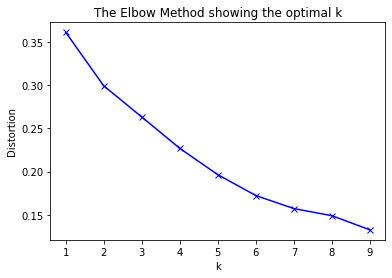

In [244]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(grouped_clustering)
    kmeanModel.fit(grouped_clustering)
    distortions.append(sum(np.min(cdist(grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [245]:
df_grouped['cluster'] = kmeans.labels_

In [251]:
df_grouped.groupby(['cluster', 'city']).mean().reset_index().melt(id_vars=['cluster', 'city']).set_index(['cluster', 'city', 'variable'])  #.to_csv('./test/results.csv', sep=';', decimal=',') / 10

,,,value
cluster,city,variable,
0,vancouver,airbnb_price_level,-0.027544
1,vancouver,airbnb_price_level,0.053653
2,vancouver,airbnb_price_level,-0.094681
3,vancouver,airbnb_price_level,-0.237764
4,vancouver,airbnb_price_level,-0.091471
...,...,...,...
0,vancouver,Travel & Transport,0.356250
1,vancouver,Travel & Transport,0.022282
2,vancouver,Travel & Transport,0.032361


In [248]:

show_nbh_clusters(df[df.city=='vancouver'].merge(df_grouped, on='neighbourhood'))


In [40]:
df[df.neighbourhood == 'Uccle']

,neighbourhood,longitude,latitude,price,city,geojson
15,Uccle,4.349771,50.80326,-0.016931,brussels,./data/airbnb/airbnb_brussels/neighbourhoods.g...


In [ ]:
(df[df.city=='brussels'

In [59]:
df_grouped[df_grouped.neighbourhood == 'Tudering-Riem']

,neighbourhood,airbnb_price_level,Arts & Entertainment,College & University,Food,...,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,cluster
38,Tudering-Riem,0.089334,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,4
